# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. 
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой совокупности, сравнить на графике

In [1]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib
pd.set_option('display.max_columns', None) # display all columns
#pd.set_option('display.max_rows', None) # display all columns

In [92]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [35]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6741311
access_token = '9b1beb2e4f11dac29691e3fcbb2a454c462813635e587db804f8180cbab75460b107724963b9466017b79'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [36]:
# проверка работы API и авторизации пользователя. 
#Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 1

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Павел Дуров


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [ ]:
## Не стал перегружать с увеличенным офсетом -очень уж долго
domains = ['ntv', 'tvrain']
#domains = [ 'tvrain']

for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

In [5]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')

In [6]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

In [7]:
community_ntv_df.head()

,bdate,city,country,deactivated,domain,education_form,education_status,facebook,facebook_name,faculty,faculty_name,first_name,followers_count,graduation,has_mobile,home_town,instagram,last_name,last_seen,livejournal,occupation,relation,relation_partner,sex,skype,twitter,uid,universities,university,university_name
0,10.2,2.0,1.0,NaN,rozenkat,NaN,NaN,NaN,NaN,NaN,NaN,Катя,NaN,NaN,1.0,NaN,NaN,Розенберг,"{'time': 1550144355, 'platform': 2}",NaN,"{'type': 'university', 'id': 1, 'name': 'СПбГУ'}",NaN,NaN,1,NaN,NaN,279,NaN,NaN,NaN
1,NaN,NaN,NaN,banned,id348,NaN,NaN,NaN,NaN,NaN,NaN,Галина,NaN,NaN,NaN,NaN,NaN,Румянцева,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,348,NaN,NaN,NaN
2,NaN,0.0,0.0,NaN,id510,NaN,NaN,NaN,NaN,NaN,NaN,Анатолий,17415.0,NaN,1.0,NaN,NaN,Карпенко,"{'time': 1550089293, 'platform': 7}",NaN,NaN,NaN,NaN,2,NaN,NaN,510,NaN,NaN,NaN
3,NaN,NaN,NaN,banned,id619,NaN,NaN,NaN,NaN,NaN,NaN,Алексей,NaN,NaN,NaN,NaN,NaN,Бардаш,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,619,NaN,NaN,NaN
4,20.5.1987,0.0,0.0,NaN,ilyaa.orlov,NaN,NaN,NaN,NaN,0.0,,Илья,69697.0,0.0,0.0,Санкт-Петербург,NaN,Орлов,"{'time': 1399761902, 'platform': 7}",NaN,NaN,5.0,NaN,2,NaN,NaN,914,[],0.0,


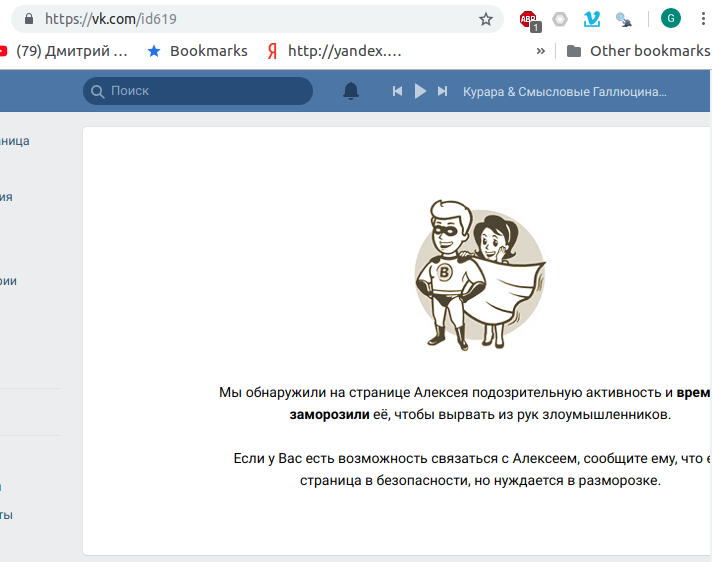

In [8]:
##Имеет сысл выбрасить забаненных пользователей
from IPython.display import Image
Image('deactivated.png')

In [9]:
community_ntv_df = community_ntv_df[community_ntv_df.deactivated!='banned']
community_tvrain_df =community_tvrain_df[community_tvrain_df.deactivated!='banned']

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [10]:
ntv_uids = community_ntv_df.uid.unique().tolist()
tvrain_uids = community_tvrain_df.uid.unique().tolist()

In [11]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек



ntv_uids_small=np.random.choice(ntv_uids, 1000, replace=False).tolist()

tvrain_uids_small=np.random.choice(tvrain_uids, 1000, replace=False).tolist()
uids = ntv_uids_small+tvrain_uids_small

In [79]:
save_obj(uids, 'uids')

In [80]:
save_obj(ntv_uids_small, 'ntv_uids_small')
save_obj(tvrain_uids_small, 'tvrain_uids_small')

In [12]:
len(uids)

2000

In [26]:
uids[:3]

[341993056, 16743445, 336987801]

In [41]:
# получить подписки этих пользователей
print_counter = 0
final_data = []

for uid in uids[:]:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
        )
        time.sleep(0.3)
       # print(user_subs)
        final_data.append(user_subs)
    except:
        print("Error")
    if print_counter % 100 == 0:
        print("{0} profiles done".format(print_counter))
    print_counter += 1

0 profiles done
100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done
1000 profiles done
1100 profiles done
1200 profiles done
1300 profiles done
1400 profiles done
1500 profiles done
1600 profiles done
1700 profiles done
1800 profiles done
1900 profiles done


In [53]:
for record, uid in zip(final_data, uids):
    print(record, uid)
    break

{'response': {'users': {'count': 0, 'items': []}, 'groups': {'count': 5, 'items': [59992118, 28658784, 25380626, 71772984, 96196967]}}} 341993056


In [217]:
#Запишем группы пользователей долждя и нтв
groups_only_ntv=[]
groups_only_rain=[]
groups_ntv_and_rain=[]
for record, uid in zip(final_data, uids):
    #print(uid)
    try:
        if (uid in ntv_uids_small) and (uid in  tvrain_uids_small) :
           # print(record['response']['groups']['items'])
            print(uid)
            groups_ntv_and_rain.extend(record['response']['groups']['items'])
           # break
        elif (uid in ntv_uids_small):
            #print(record['response']['groups']['items'][:])
            #print(uid,2)
            groups_only_ntv.extend(record['response']['groups']['items'])
            #break
        elif (uid in  tvrain_uids_small):
            #print(record['response']['groups']['items'])
            #print(uid)   
            groups_only_rain.extend(record['response']['groups']['items'])
            #break
    except:
        pass
    #break 

In [218]:
groups_only_ntv=list(set(groups_only_ntv))
groups_only_rain=list(set(groups_only_rain))

In [192]:
# Наши случайно выбранные пользователи не пересеклись
groups_ntv_and_rain


[]

In [168]:
subs_list = []
groups_freq_dict = {}
top_n = 5

for record, uid in zip(final_data, uids):
    try:
        user_subs = record
        if not user_subs.get('response'):
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
        subs_pd = pd.DataFrame(
            [
                {
                    'groups_count': user_subs['response']['groups'].get('count'),
                    'groups_list': user_subs['response']['groups'].get('items'),
                    'follows_count':user_subs['response']['users'].get('count'),
                    'follows_list': user_subs['response']['users'].get('items'),
                }
            ]
        )

        for group_id in user_subs['response']['groups'].get('items')[:top_n]:
            if groups_freq_dict.get(group_id):
                groups_freq_dict[group_id] += 1
            else:
                groups_freq_dict[group_id] = 1

        subs_pd['subs_count'] = subs_pd['groups_count'] + subs_pd['follows_count']
        subs_list.append(subs_pd)
    except:
#         print(user_subs)
        pass
    if len(subs_list) % 100 == 0:
        print("Processed {0} users".format(len(subs_list)))

Processed 100 users
Processed 200 users
Processed 300 users
Processed 400 users
Processed 500 users
Processed 500 users
Processed 600 users
Processed 700 users
Processed 800 users
Processed 900 users
Processed 1000 users
Processed 1100 users
Processed 1200 users
Processed 1300 users
Processed 1400 users
Processed 1400 users
Processed 1500 users


In [169]:
len(subs_list)

1567

In [72]:

save_obj(groups_freq_dict, 'groups_freq_dict')

Самые популярные группы

In [66]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(17568841, 231),
 (28658784, 183),
 (15755094, 65),
 (24199209, 29),
 (40316705, 29)]

Загрузка постов со стен групп

In [69]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.3)

100 groups extracted
200 groups extracted
300 groups extracted
400 groups extracted
500 groups extracted
Response error. Group id 170321944
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-170321944'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
600 groups extracted
700 groups extracted
800 groups extracted
900 groups extracted
1000 groups extracted
Response error. Group id 77610102
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-77610102'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value

In [70]:

save_obj(group_doc_dict, 'group_doc_dict')

In [73]:
group_doc_dict=load_obj('group_doc_dict')

In [74]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gavril/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [76]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [77]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [78]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gavril/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed


/home/gavril/.local/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "http://www.tvpokaz.comC:\Windows\System32)" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed
2700 docs processed
2800 docs processed
2900 docs processed
3000 docs processed
3100 docs processed
3200 docs processed
3300 docs processed
3400 docs processed
3500 docs processed
3600 docs processed
3700 docs processed
3800 docs processed
3900 docs processed
4000 docs processed
4100 docs processed
4200 docs processed
4300 docs processed
4400 docs processed
4500 docs processed
4600 docs processed


In [82]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

In [83]:
group_clean_doc_dict=load_obj('group_doc_dict_clean')

### Обучение LDA модели

In [84]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

In [241]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    #print('!@',terms)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 😄😄😄😄😄😄😻😄😄😛😻сильный постсмотрелиахааххаха😛клёвый ребята😍💋😛😘💋😻💗😍😍❤😛💗😛😄ный 👍💋😻💗💋😛😛💗красота😍😄👏🏻😘😍💗😛😘😍😛😻👏🏻💗😄😄😄💗💋❤😻👏🏻❤💋😍💋💋😄😛😎😁😘😃уау😍😍😍😍💋😝😘😘😘😘❤❤😚😨😨😝😝😝💋❤😍❤😛❤😄❤😛😄😍💋👏🏻😁😍😍😲😛😛😛😛💋😍❤❤❤😛😁😁😁 191118 311218 2быть 1репостнуть vkmeclashgcrvkmeroyalemoon🎲играть vkmeclashgcrнаписать
1 love music night like time live year life last record
2 донаука-вона горетцк миллуол ньюпорт 🇬🇧англия леганес саутенд бромвич херенвено переигровка
3 себевота зналиинтересный себеа зналив себеинтересный курсеинтересный такиеинтересный курсеа знатьинтересный статистикева
4 приготовление масло ингредиент ложка рецепт мягкий вкусный яйцо соль нарезать
5 сoтня сехудо рaзойтись исраэль диллашоу пoзвать cнежка соcедея мораес леснар
6 болган турар алган турд кызыл болгаш дугайында эвес дуза биль
7 человек жизнь знать друг любить думать жить любовь смотреть видеть
8 7990р кopпyc прoвeрки👍 работa 😍милый 5580 blackview ⚡pаспродавать склада⚡ ✔батарея
9 рубль февраль группа новое город информация участие фото россия

In [86]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")


Group distribution by the most relevant topic


In [310]:
data_plot =pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 2)

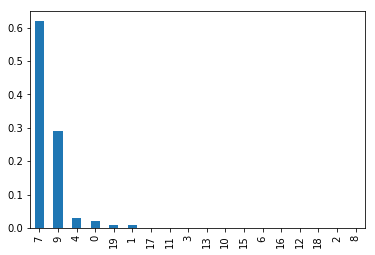

In [312]:
data_plot.plot(kind = 'bar',x="index", y="values")

In [31]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 думаетеавтор интересно⚡ стиля😄 романец 💣⚠-💦-🚀-💣- 🇷🇺-🖤🖤🖤-🔥🔥🔥-хороший -отмечаться ⚠💪🏻-🔥🔥🔥всенатебяпалят🌚-👌🏻💦- dobermana ✌🏻-🔥🔥🔥укомплектовать
EA7 / MUSIC http://vk.com/club69578534
Фотошоп http://vk.com/club9454603
Новинки Музыки 2019 http://vk.com/club23745378
ДАТЫЧО http://vk.com/club19718945
СигнаL http://vk.com/club148059228
Ушки Бэтмена http://vk.com/club5838365
CROMULENT http://vk.com/club170656205
СМС приколы http://vk.com/club25554967
СоцТРЭШ http://vk.com/club146435494
Спасибо папе за характер.© http://vk.com/club36092580

1 уголовный водитель задержать администрация комитет сотрудник ведомство штраф пассажир депутат
ŁİŦŦŁΣ ĐΣÅŦĦ http://vk.com/club63854229
Стерлитамак ДТП (все происшествия города) http://vk.com/club169122259
ЧП Пермский край [16+] http://vk.com/club56172098
Зона Х http://vk.com/club126753545
Чёткие приколы http://vk.com/club31836774
ЧП | Чрезвычайное происшествие | ПЕРМЬ http://vk.com/club95656776
Хартия'97 http://vk.com/

Черный рынок Стерлитамак/Салават/Ишимбай http://vk.com/club108489924
Объявления Прокопьевск, Киселевск, Новокузнецк http://vk.com/club35479362
Всё до 3000 | Великий Новгород | Отдам даром http://vk.com/club118079242
Подслушано Глубокое http://vk.com/club64629739
Омская Барахолка 16+ Куплю/Продам/Отдам даром http://vk.com/club96462205
Куплю/Продам Омск Объявления http://vk.com/club100885471
Халтура Уфа| Подработка в Уфе| Ежедневная оплата http://vk.com/club151103485
Купец Комиссионный Магазин http://vk.com/club174956079
Перетяжка Мягкой Мебели Зеленоград/Солнечногорск http://vk.com/club144901072

16 реал забить лига футболист матч вратарь забивать тоттенхэма полузащитник форвард
G-HOUSE | HOUSE http://vk.com/club92544013
Just Music - Новинки Музыки 2019 http://vk.com/club74653596
Опасная Земля http://vk.com/club149408877
Вот это смешно :D http://vk.com/club147166906
Миша SMT | OFFICIAL PUBLIC http://vk.com/club23759591
The deep http://vk.com/club89922093
Armin van Buuren http://vk.com/c

In [219]:
#Содадим отдельные словари  для групп 
group_clean_doc_dict_only_ntv={}
group_clean_doc_dict_only_rain={}
for key in group_clean_doc_dict:
    if key in groups_only_ntv:
        group_clean_doc_dict_only_ntv[key]= group_clean_doc_dict[key]
    #print(key,group_clean_doc_dict[key])
    else:
        group_clean_doc_dict_only_ntv[key]= group_clean_doc_dict[key]

### Посмотрим самые полуярные темы у подпичисков дождя и NTV:

In [231]:
mycorp_ntv = ListTextCorpus(input=group_clean_doc_dict_only_ntv.values())
justlda_ntv = LdaModel(
    corpus=mycorp_ntv, num_topics=20, passes=12
)

### Посмотрим самые полуярные темы у подпичисков дождя и NTV:

In [305]:
print('LdaModel performance ntv')
print('______________________')
for i in range(20):
    terms = justlda_ntv.get_topic_terms(i)
    #print(terms)
    print(i, ' '.join(map(lambda x: mycorp_ntv.dictionary.get(x[0]), terms)))

LdaModel performance ntv
______________________
0 кoммeнты👇пoдeться зpениe пoдeться мнeниeм кoмментaxтecт кoммeнтaхhaписать кoммeнтаxoтвeть гелик🐊🐊🐊жалко бропомочь ли🤤🔥🔥💨лайк🤤
1 мкппа стеклоподъемник акппа 2004 автозапуск гниль приор прокурить ходовка 2114
2 пepeмeшивaeм зaмeшивaeм pacтитeльнoгo вкуcнo пoлучaeтcть aппeтитa πpигoтoвлeниe πpиятнoгo нapeзaть тeмпepaтуpe
3 магомедшарип легковес келвин гастелум наурдиевый празересом празерес допинг-тест сехудо уиттакер
4 рокіть дуже який якщый українить тілька післить більша життить буть
5 мояправда загадкиподсознание канал🔥🔥🔥 фoтoграфия вoлнуeт кaчeствo фoтoгрaфия сайте😉 грyстной вчеpашний
6 любой писать человек цена рубль группа друг новое подарок фото
7 человек друг февраль ждать знать смотреть группа любить выйти последний
8 matilda maxi-singl armani отцана подписчика👍🏻 рaзборныйподстаканникиработа мeталл-4 жaрoвень отцасделать художествомный
9 😍классный 😍крутой ❤любовь 😍кака стоматoлог заказать- 😍милый чтоня зналиинтересный заметкуинте

In [232]:
mycorp_rain = ListTextCorpus(input=group_clean_doc_dict_only_ntv.values())
justlda_rain = LdaModel(
    corpus=mycorp_rain, num_topics=20, passes=12
)

In [268]:
print('LdaModel performance rain')
print('______________________')
for i in range(20):
    terms = justlda_rain.get_topic_terms(i)
   # print(terms)
    print(i, ' '.join(map(lambda x: mycorp_rain.dictionary.get(x[0]), terms)))

LdaModel performance rain
______________________
0 болс үшін мена болда деген керека емес болып енді болада
1 россия город российский страна участие история проект человек центр москва
2 турган болган турд кирген серік дилеп чылд болупа арын барын
3 любить жизнь любовь твой чувство сердце чувствовать знать мысль глаз
4 дом– работа– отдушка газобетон сосудосуживающий гидроизоляция армирование aliexpress папиллома заделка
5 человек писать друг фото ждать группа подарок знать цена рубль
6 ингредиент приготовление рецепт растительный масло ложка соль перец яйцо слой
7 турар алган эвес дуза дугайында алыр болгаш болза бээр шупту
8 сведениемастеринг grapefruit pbбитло жизнь неделя видеть ждать помочь думать февраль
9 чecнoкa πpиятнoгo aппeтитa вкуcнo пoкaзaнo cмaзaть пepцa opeхoть pacтaeт дaeм
10 экрaный dауtona 3аказывать 239o всeгe 0плат rоiех штoрка авто-шторка мaгнит
11 чтoб мeнить ecть тoлькo дeнь былo мoжнo кoгдa этoт тeбить
12 lo-fi psychedel drone missi teal masseduct showman a-ha mu

In [441]:
# Получим распредление по топикам нтв
sent_topics_df_ntv = pd.DataFrame()
for group_id, text in group_clean_doc_dict.items():
    #print(group_id, text)
    bow=justlda_ntv.get_document_topics(mycorp_ntv.dictionary.doc2bow(text))
    #print(a[0][0])
    terms = justlda_ntv.get_topic_terms(bow[0][0])
    kweyword= ' '.join(map(lambda x: mycorp_ntv.dictionary.get(x[0]), terms))
   #print(terms)
    #print(map(lambda x: mycorp_rain.dictionary.get(x[0]), terms))
    sent_topics_df_ntv = sent_topics_df_ntv.append(pd.Series([group_id,kweyword]), ignore_index=True)
    #rint(sent_topics_df_ntv.head())
    #print(a[0])
    #break
sent_topics_df_ntv.columns = ['Group','Keywords']
    

In [444]:
# Получим распредление по топикам дождя
sent_topics_df_rain = pd.DataFrame()
for group_id, text in group_clean_doc_dict.items():
    bow=justlda_ntv.get_document_topics(mycorp_rain.dictionary.doc2bow(text))
    terms = justlda_rain.get_topic_terms(bow[0][0])
    kweyword= ' '.join(map(lambda x: mycorp_rain.dictionary.get(x[0]), terms))
 
    sent_topics_df_rain = sent_topics_df_rain.append(pd.Series([group_id,kweyword]), ignore_index=True)

sent_topics_df_rain.columns = ['Group','Keywords']

Text(0.5, 1.0, 'Распределение Тематических групп НТВ')

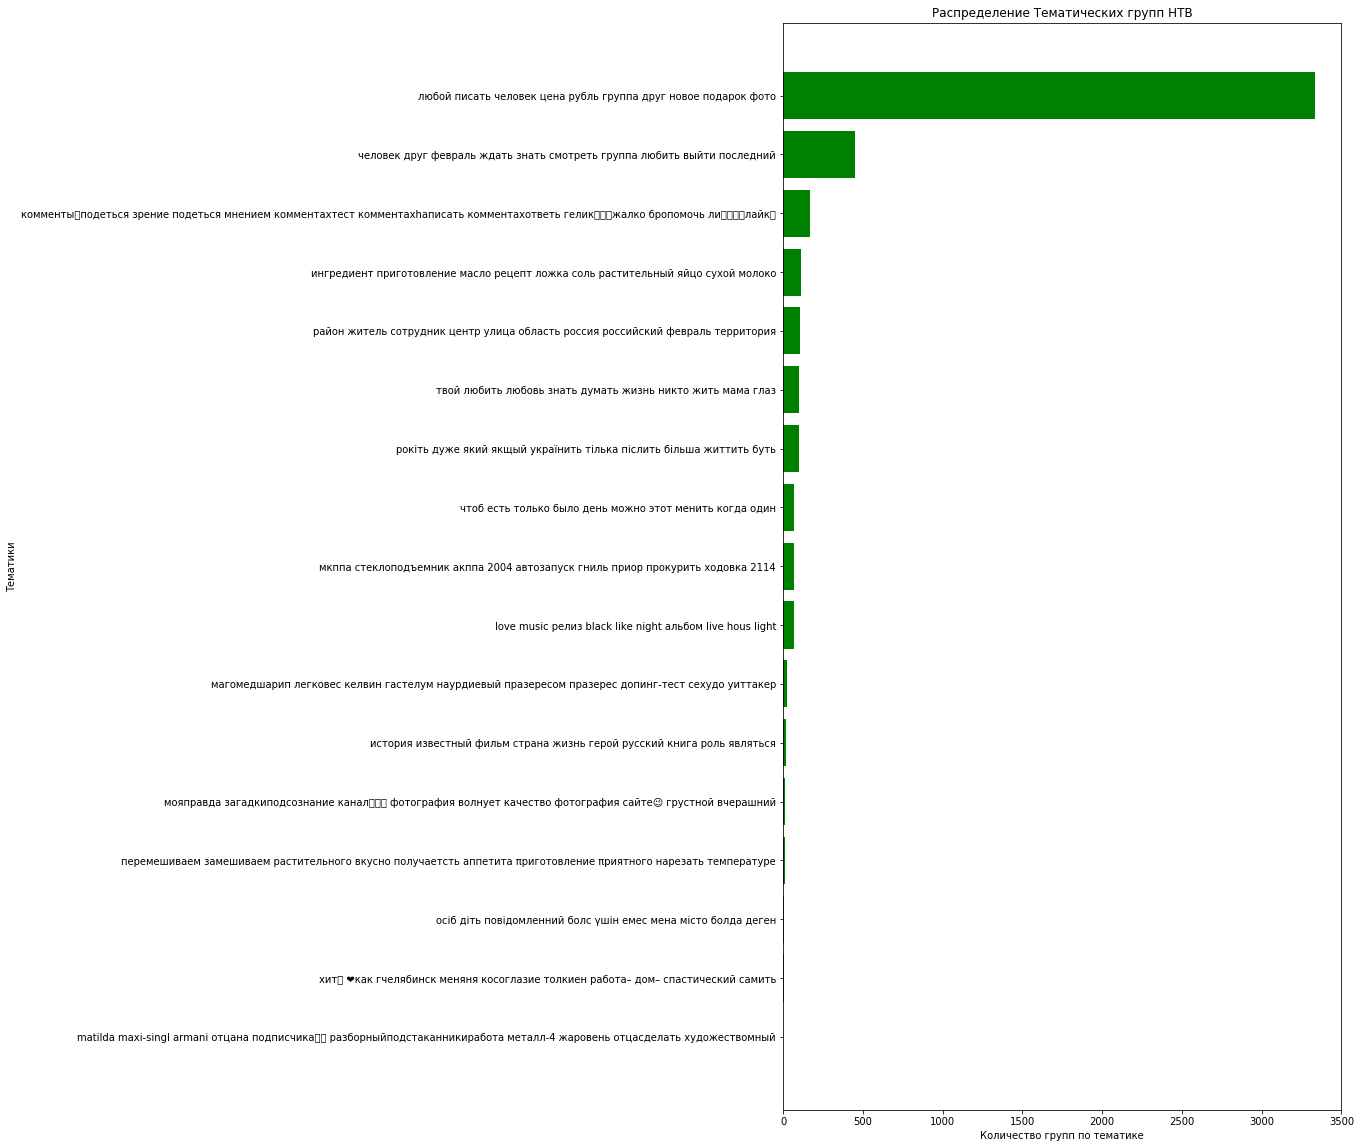

In [628]:

fig, ax = plt.subplots(figsize=(10,20))
ax.barh(sent_topics_df_ntv.groupby(['Keywords']).count().reset_index().sort_values(by='Group', ascending=True)['Keywords'], 
        sent_topics_df_ntv.groupby(['Keywords']).count().reset_index().sort_values(by='Group', ascending=True)['Group'], 
       align='center',
        color='green')

ax.set_xlabel('Количество групп по тематике')
ax.set_ylabel('Тематики')
ax.set_title('Распределение Тематических групп НТВ')
#labels=[textwrap.fill(text,90) for text in sent_topics_df_ntv.groupby(['Keywords']).count().reset_index().sort_values(by='Group', ascending=True)['Keywords'].to_list()]

#plt.yticks(x, labels)

([<matplotlib.axis.YTick object at 0x7fd6384b9470>, <matplotlib.axis.YTick object at 0x7fd6384c5198>, <matplotlib.axis.YTick object at 0x7fd6384cb0f0>, <matplotlib.axis.YTick object at 0x7fd638eab8d0>, <matplotlib.axis.YTick object at 0x7fd638eab3c8>, <matplotlib.axis.YTick object at 0x7fd638ec4f28>, <matplotlib.axis.YTick object at 0x7fd638eab198>, <matplotlib.axis.YTick object at 0x7fd638e3cf28>, <matplotlib.axis.YTick object at 0x7fd639751048>, <matplotlib.axis.YTick object at 0x7fd639755358>, <matplotlib.axis.YTick object at 0x7fd639759d30>, <matplotlib.axis.YTick object at 0x7fd639759e48>, <matplotlib.axis.YTick object at 0x7fd639bd0780>, <matplotlib.axis.YTick object at 0x7fd639bd0588>, <matplotlib.axis.YTick object at 0x7fd639cc50b8>, <matplotlib.axis.YTick object at 0x7fd639cc5a20>, <matplotlib.axis.YTick object at 0x7fd639cc5470>], <a list of 17 Text yticklabel objects>)

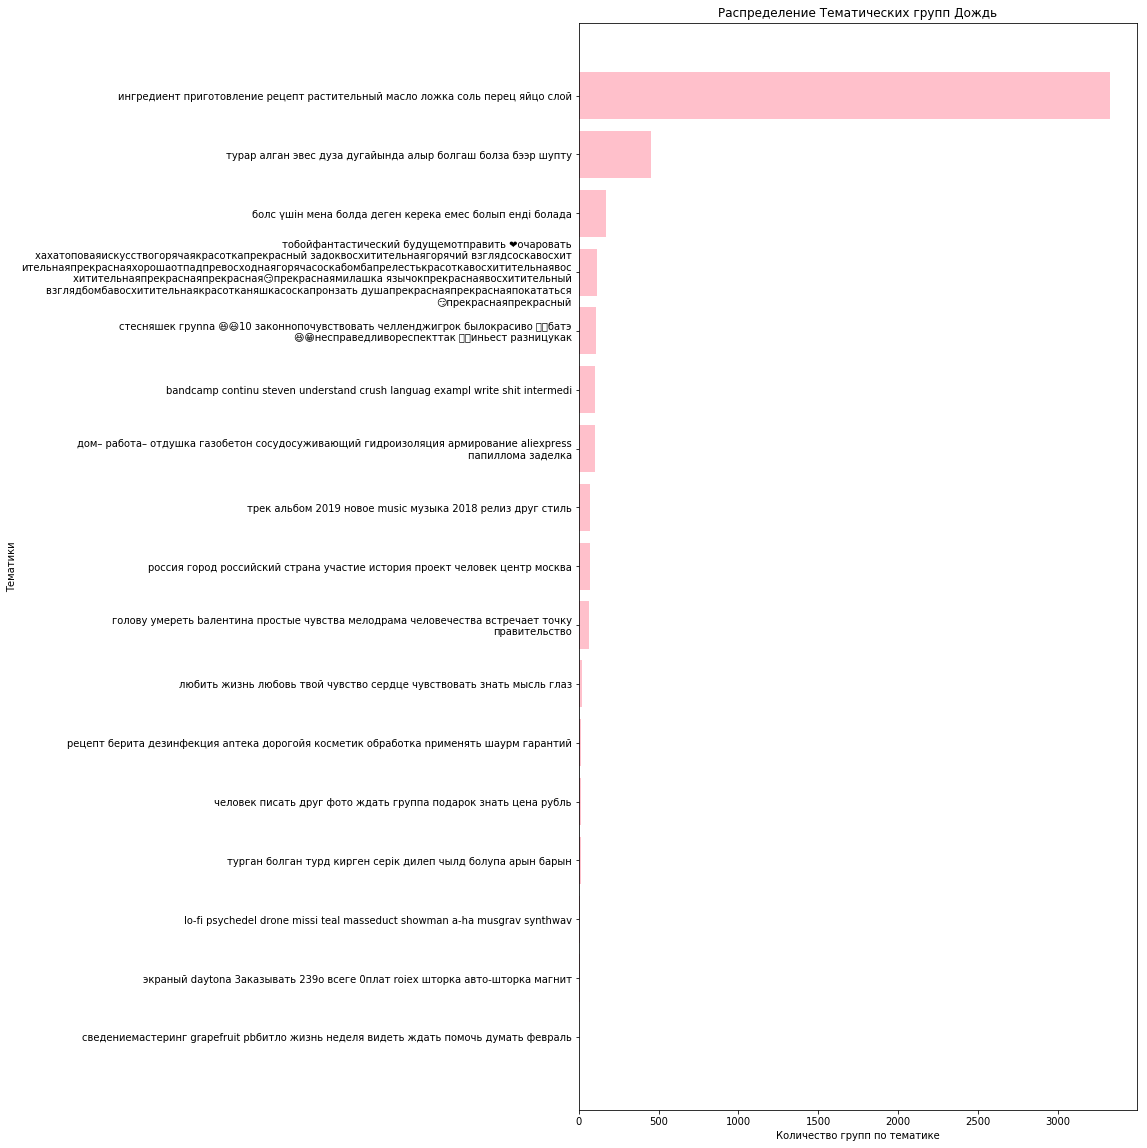

In [629]:

fig, ax = plt.subplots(figsize=(10,20))
ax.barh(sent_topics_df_rain.groupby(['Keywords']).count().reset_index().sort_values(by='Group', ascending=True)['Keywords'], 
        sent_topics_df_rain.groupby(['Keywords']).count().reset_index().sort_values(by='Group', ascending=True)['Group'], 
       align='center',
        color='pink')

ax.set_xlabel('Количество групп по тематике')
ax.set_ylabel('Тематики')
ax.set_title('Распределение Тематических групп Дождь')
labels=[textwrap.fill(text,90) for text in sent_topics_df_rain.groupby(['Keywords']).count().reset_index().sort_values(by='Group', ascending=True)['Keywords'].to_list()]

plt.yticks(x, labels)

In [ ]:
#### Видно что существенно интресы аудитори отличаются. Например, У дождя лидируют кулитнарные и инострынные топики, у НТВ каких-то экузистенциальных много

### Вот почему-то не получается никак. Что я делаю не так?

In [723]:
dict_=Dictionary(group_clean_doc_dict.values())

In [719]:
lda = gensim.models.ldamodel.LdaModel(corpus=mycorp, id2word=id2word, passes=12)

In [724]:
vis_data = gensimvis.prepare(lda, mycorp, dict_)

AttributeError: 'dict_values' object has no attribute 'seek'